 * @ Author: Yohei Ohto
 * @ Create Time: 2025-03-31 18:54:24
 * @ Modified time: 2025-07-29 12:40:28

# About This Code
## Data
- `lookup`:  
    A dictionary containing structure similarity and physicochemical property similarity scores for each molecular pair. Used in the genetic algorithm's evaluation function to calculate scores for all pairs within an individual (set of molecules).

- `cas_tox`:  
    A DataFrame containing toxicity scores, CAS numbers, SMILES, and other information for each molecule. Used for toxicity score standardization and as an index reference for the molecules being optimized.

- `val`:  
    A DataFrame of the validation molecule set (including PubChem IDs and SMILES). Used to determine the size of the set to optimize (`IND_INIT_SIZE`) and for final evaluation and visualization.

## Result
- `../../data/result/{test_name}/GA_{trys}/GA/score.tsv`:  
    Contains the mean and standard deviation of each objective (structure similarity, physicochemical property similarity, toxicity variation) for the population at each generation. Used to track the optimization process over time.

- `../../data/result/{test_name}/GA_{trys}/GA/top_5.tsv`:  
    Stores the top individuals (solutions) from each generation, typically the best 5 according to the multi-objective criteria. Useful for analyzing the progression of elite solutions.

- `../../data/result/{test_name}/GA_{trys}/data.tsv`:  
    Contains the raw fitness values for all individuals in the population at each generation. Enables detailed analysis of the population's diversity and fitness distribution.

- `../../data/result/{test_name}/GA_{trys}/memo.txt`:  
    A text file summarizing the parameters and settings used for the genetic algorithm run (e.g., weights, population size, number of generations).

- `../../data/result/{test_name}/GA_{trys}/pareto_front.tsv`:  
    Lists the individuals on the final Pareto front, representing the set of non-dominated solutions found by the multi-objective optimization.

- `../../data/result/{test_name}/GA_{trys}/fig2/A_structure.png`, `../../data/result/{test_name}/GA_{trys}/fig2/B_phisical_property.png`, `../../data/result/{test_name}/GA_{trys}/fig2/C_toxicity.png`:  
    Plots showing the progression of each objective (structure similarity, physicochemical property similarity, toxicity variation) across generations, with the best solution highlighted.

- `../../data/result/{test_name}/GA/GA_{trys}/fig3/fig3_parate.png`:  
    A scatter plot comparing the initial and final populations in the objective space, colored by toxicity score, to visualize optimization progress and trade-offs.

- `../../data/result/{test_name}/GA/fig4/D_GA_chems.png`:  
    An image grid of the chemical structures (SMILES) corresponding to the best solution found by the genetic algorithm.

- `../../data/result/{test_name}/GA/fig1/D_valid_chems.png`:  
    An image grid of the chemical structures in the validation set, used for comparison with the optimized results.  
    Contains the mean and standard deviation of each objective (structure similarity, physicochemical property similarity, toxicity variation) for the population at each generation. Used to track the optimization process over time.

# Library Imports

In [ ]:
import os
import sys

current_dir = os.getcwd()
parent_parent_dir = os.path.dirname(os.path.dirname(current_dir))
src_dir = os.path.join(parent_parent_dir, 'src')
sys.path.append(src_dir)

import ast
import itertools
import math
import random
import time
from math import comb
from statistics import variance

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from deap import algorithms, base, creator, tools
from ga import not_dup, rand_nodup
from rdkit import Chem
from rdkit.Chem import Draw
from scipy.stats import norm
from util import pickle_load, robust_z

# Validation test name

In [ ]:
test_num = "0905"
ligand = "anta"

# Parameter

In [ ]:
date = 241219
num = 1
N_GEN = 1000
POP_SIZE = 100
CX_PB = 0.5
MUT_PB = 0.2
weight = (-10,2,1)
# tox_scoring = "descrete"
tox_scoring = "continuous"

In [339]:
if ligand in ["ago", "anta"]:
    test_name = test_num + "_" + ligand
else:
    test_name = test_num
    
lookup = pickle_load(f"../../data/processed/{test_name}/for_GA_lookup.pickle")
cas_tox = pd.read_csv(f"../../data/processed/{test_name}/cas_sev_use.tsv", sep="\t", header=None)
val = pd.read_csv(f"../../data/processed/{test_name}/validation_pubchem.tsv", sep="\t", header=None) 

# Data Preparation

In [341]:
IND_INIT_SIZE = len(val)
trys = str(date) + "_" + str(num)
memo = f"""w = {weight}, date = {date}, num = {num}, gen = {N_GEN}, pop = {POP_SIZE} IND_INIT_SIZE = {IND_INIT_SIZE}, CX_PB = {CX_PB}, MUT_PB = {MUT_PB}"""

In [342]:
all_cass = []
all_toxs = []
for i in range(len(cas_tox)):
    all_cass.append(cas_tox.iloc[i,0])
    all_toxs.append(cas_tox.iloc[i,1])

# mean = np.mean(all_toxs)
# std_dev = np.std(all_toxs)
# standardized_toxs = (all_toxs - mean) / std_dev

In [ ]:
if tox_scoring == "continuous":
    standardized_toxs = robust_z(all_toxs)
elif tox_scoring == "descrete":
    standardized_toxs = all_toxs

# Set toolbox and Custom Functions 

In [344]:
def binomial_likelihood(k, n, theta):
  return np.math.factorial(n) / (np.math.factorial(k) * np.math.factorial(n - k)) * theta**k * (1 - theta)**(n - k)

In [345]:
def multi_objective_optimization(individual):
    structure_score = 0
    phisical_score = 0
    penalty = [100000, -100000, -100000]

    if len(individual) != IND_INIT_SIZE:
        return penalty[0], penalty[1], penalty[2]
    
    toxs = []
    for i in range(len(list(individual))):
        num = list(individual)[i]
        toxs.append(standardized_toxs[num])

    if tox_scoring == "descrete":
        count_t = 0
        for i in range(len(toxs)):
            if toxs[i] == 1:
                count_t += 1
        N = len(toxs)
        p = 0.5
        likelihood = comb(N, count_t) * (p**count_t) * ((1 - p)**(N - count_t))
        toxicity_score = math.log(likelihood)

    elif tox_scoring == "continuous":
        toxicity_score = np.std(toxs)

    t = list(itertools.combinations(individual,2))
    for i in range(len(t)):
        if t[i][0] == t[i][1]:
            print("!", flush=True)
            return penalty[0], penalty[1], penalty[2]

    for i in range(len(t)):
        try:
            dict_t = lookup[f"{all_cass[t[i][0]]}, {all_cass[t[i][1]]}"]
        except:
            dict_t = lookup[f"{all_cass[t[i][1]]}, {all_cass[t[i][0]]}"]
        structure = dict_t[0]
        phisical = dict_t[1]
        structure_score += structure
        phisical_score += phisical

    return structure_score, phisical_score, toxicity_score

In [346]:
def mutSet(individual):
    for i in range(len(individual)):
        ind_list = list(individual)
        if len(ind_list) != IND_INIT_SIZE:
            return 1
        if random.random() < 1:
            n = random.randint(0,IND_INIT_SIZE-1)
            ind_list[n] = not_dup(0, len(cas_tox)-1, ind_list)
            individual = creator.Individual(ind_list) 
    return individual

In [347]:
def cxSet(ind1, ind2):
    ind_1 = list(ind1)
    ind_2 = list(ind2)
    a = random.randint(0,IND_INIT_SIZE-1)
    ind1 = ind_1[:a] + ind_2[a:]
    ind2 = ind_1[a:] + ind_2[:a]
    ind1 = creator.Individual(ind1)
    ind2 = creator.Individual(ind2)  
    return ind1, ind2

In [348]:
creator.create("Fitness", base.Fitness, weights=weight)
creator.create("Individual", set, fitness=creator.Fitness)

toolbox = base.Toolbox()
toolbox.register("attr_item", random.randint, 0, len(cas_tox)-1)
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_item, IND_INIT_SIZE)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("evaluate", multi_objective_optimization)
toolbox.register("mate", cxSet)
toolbox.register("mutate", mutSet)
toolbox.register("select", tools.selNSGA2)

/opt/pip-env/lib/python3.10/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'Fitness' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/opt/pip-env/lib/python3.10/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


# Do Multi Objective Optimization

In [ ]:
def main(CX_PB, MUT_PB,IND_INIT_SIZE):
    random.seed(42)
    CX_PB = CX_PB
    MUT_PB = MUT_PB
    IND_INIT_SIZE = IND_INIT_SIZE
    tsv = []
    tsv_2 = []
    tsv_3 = []

    pop = toolbox.population(n=POP_SIZE)

    for x in range(len(pop)):
        if len(pop[x]) != IND_INIT_SIZE:
            while len(pop[x]) == IND_INIT_SIZE:
                pop[x].add(random.randint(0, len(cas_tox)-1))

    fitnesses = list(map(toolbox.evaluate, pop))
    for ind, fit in zip(pop, fitnesses):
        ind.fitness.values = fit

    fits = [ind.fitness.values[0] for ind in pop]

    g = 0
    while g < N_GEN:
        g = g + 1
        if g == 10:
            now = time.ctime()
            gentime = time.strptime(now)
            print(time.strftime("%Y/%m/%d %H:%M", gentime), flush=True)
        if g % 100 == 0:
            now = time.ctime()
            gentime = time.strptime(now)
            print(f"-------------------{g}------------------")
            print(time.strftime("%Y/%m/%d %H:%M", gentime), flush=True)
        offspring = toolbox.select(pop, 100)
        offspring = list(map(toolbox.clone, offspring))

        for child1, child2 in zip(offspring[::2], offspring[1::2]):
            if random.random() < CX_PB:
                child1, child2 = toolbox.mate(child1, child2)
                del child1.fitness.values
                del child2.fitness.values
            
            if len(child1) == IND_INIT_SIZE: 
                offspring.append(child1)
            if len(child2) == IND_INIT_SIZE:
                offspring.append(child2)

        for mutant in offspring:
            if random.random() < MUT_PB:
                mutant = toolbox.mutate(mutant)
                if mutant == 1:
                    continue
                offspring.append(mutant)

        invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
        fitnesses = map(toolbox.evaluate, invalid_ind)
        for ind, fit in zip(invalid_ind, fitnesses):
            ind.fitness.values = fit

        list_off = []
        for ind in offspring:
            list_off.append(list(ind))
        
        list_a = []
        for ind in list_off:
            if ind not in list_a:
                list_a.append(ind)
        
        li_of = []
        for ind in list_a:
            li_of.append(creator.Individual(ind))

        tsv_2.append(tools.selBest(li_of,100))

        pop[:] = offspring

        for x in range(len(pop)):
            if len(pop[x]) != IND_INIT_SIZE:
                while len(pop[x]) != IND_INIT_SIZE:
                    pop[x].add(random.randint(0, len(cas_tox)-1))
        
        col = []
        fits_0 = [ind.fitness.values[0] for ind in pop]

        length = len(pop)
        mean = sum(fits_0) / length
        sum2 = sum(x*x for x in fits_0)
        std = abs(sum2 / length - mean**2)**0.5
        col.append(mean)
        col.append(std)

        fits_1 = [ind.fitness.values[1] for ind in pop]

        length = len(pop)
        mean = sum(fits_1) / length
        sum2 = sum(x*x for x in fits_1)
        std = abs(sum2 / length - mean**2)**0.5
        col.append(mean)
        col.append(std)

        fits_2 = [ind.fitness.values[2] for ind in pop]

        length = len(pop)
        mean = sum(fits_2) / length
        sum2 = sum(x*x for x in fits_2)
        std = abs(sum2 / length - mean**2)**0.5
        col.append(mean)
        col.append(std)

        tsv.append(col)
        
        aaa = []
        for ind in pop:
            col = []
            for y in range(3):
                col.append(ind.fitness.values[y])
            aaa.append(col)
        tsv_3.append(aaa)

    best_ind = tools.selNSGA2(pop, 1)[0]
    print("Best individual is %s, %s" % (best_ind, best_ind.fitness.values))

    os.makedirs(f"../../data/result/{test_name}/GA_{trys}/GA", exist_ok=True)
    os.makedirs(f"../../data/result/{test_name}/GA_{trys}/fig3", exist_ok=True)

    pd.DataFrame(tsv).to_csv(f"../../data/result/{test_name}/GA_{trys}/GA/score.tsv", sep="\t", header=None, index=False)
    pd.DataFrame(tsv_2).to_csv(f"../../data/result/{test_name}/GA_{trys}/GA/top_5.tsv", sep="\t", header=None, index=False)
    pd.DataFrame(tsv_3).to_csv(f"../../data/result/{test_name}/GA_{trys}/GA/data.tsv", sep="\t", header=None, index=False)
    with open(f"../../data/result/{test_name}/GA_{trys}/GA/memo.txt", "w") as f:
        f.write(memo)

    pareto_front = tools.ParetoFront()
    pareto_front.update(pop)
    pd.DataFrame(pareto_front).to_csv(f"../../data/result/{test_name}/GA_{trys}/fig3/fig3_pareto_front.tsv", sep="\t", header=None, index=False)

In [350]:
print(IND_INIT_SIZE)
if __name__ == "__main__":
    main(CX_PB, MUT_PB, IND_INIT_SIZE)
now = time.ctime()
cnvtime = time.strptime(now)
print(time.strftime("%Y/%m/%d %H:%M", cnvtime), flush=True)

9
2024/12/24 12:02
-------------------100------------------
2024/12/24 12:02
-------------------200------------------
2024/12/24 12:02
-------------------300------------------
2024/12/24 12:02
-------------------400------------------
2024/12/24 12:02
-------------------500------------------
2024/12/24 12:02
-------------------600------------------
2024/12/24 12:02
-------------------700------------------
2024/12/24 12:02
-------------------800------------------
2024/12/24 12:02
-------------------900------------------
2024/12/24 12:02
-------------------1000------------------
2024/12/24 12:03
Best individual is Individual({384, 774, 5194, 2091, 4812, 1997, 1072, 2138, 1948}), (1.8173523492742345, 15.253234139144926, 0.6359150349392931)
2024/12/24 12:03


# Result - fig2

In [ ]:
pops = pd.read_csv(f"../../data/result/{test_name}/GA_{trys}/GA/top_5.tsv", sep="\t", header=None)

In [ ]:
best_pop = pops.iloc[-1,0]
best_pop = best_pop.replace("Individual(", "").replace(")", "")
best_pop = list(ast.literal_eval(best_pop))

best_score = multi_objective_optimization(best_pop)

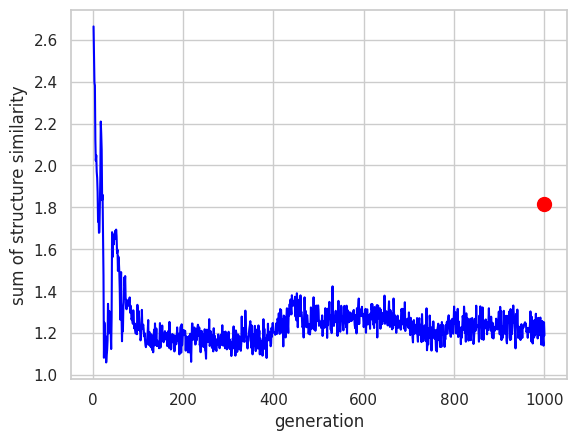

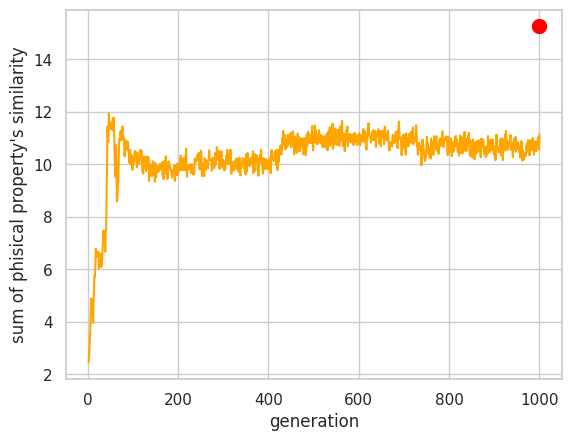

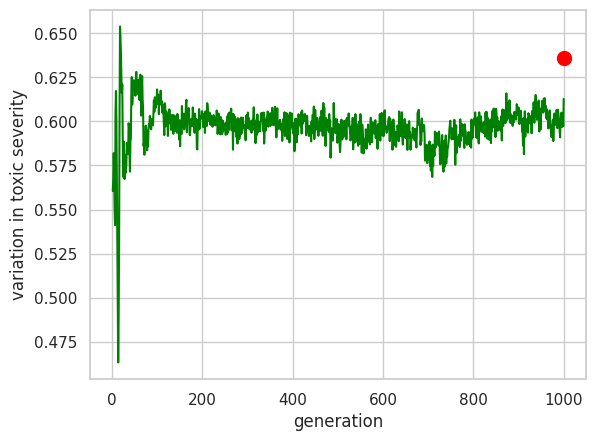

In [ ]:
scores = pd.read_csv(f"../../data/result/{test_name}/GA_{trys}/GA/score.tsv", sep="\t", header=None)
n = 1000
m_tani = []
s_tani = []
m_butsu = []
s_butsu = []
m_tox = []
s_tox = []
m_mw = []
s_mw = []

for i in range(1, n):
    m_tani.append(scores.iloc[i,0])
    s_tani.append(scores.iloc[i,1])
    m_butsu.append(scores.iloc[i,2])
    s_butsu.append(scores.iloc[i,3])
    m_tox.append(scores.iloc[i,4])
    s_tox.append(scores.iloc[i,5])
    #m_mw.append(scores.iloc[i,6])
    #s_mw.append(scores.iloc[i,7])

os.makedirs(f"../../data/result/{test_name}/GA_{trys}/fig2", exist_ok=True)

plt.style.use('default')
sns.set()
sns.set_style('whitegrid')
sns.set_palette('Set1')

x = list(range(2, n+1))

fig_1 = plt.figure()
ax_1 = fig_1.add_subplot(1, 1, 1)

ax_1.plot(x, m_tani, label='similaryty of chemical structures', color= "blue")
ax_1.plot(1000, best_score[0], marker=".", color="red", markersize=20)
#ax_1.legend(prop={'family':'Yu Gothic'})
ax_1.set_xlabel("generation")
ax_1.set_ylabel("sum of structure similarity")
plt.savefig(f"../../data/result/{test_name}/GA_{trys}/fig2/A_structure.png")

fig_2 = plt.figure()
ax_2 = fig_2.add_subplot(1, 1, 1)

#ax_1.errorbar(x, m_tani, yerr=s_tani, marker='o', capthick=1, capsize=10, lw=1,  alpha=0.2)
ax_2.plot(x, m_butsu, label='similarity among chemical propaties', color="orange")
ax_2.plot(1000, best_score[1], marker=".", color="red", markersize=20)
#ax_2.legend(prop={'family':'Yu Gothic'})
ax_2.set_xlabel("generation")
ax_2.set_ylabel("sum of phisical property's similarity")
plt.savefig(f"../../data/result/{test_name}/GA_{trys}/fig2/C_phisical_property.png")
#ax_2.errorbar(x, m_butsu, yerr=s_butsu, marker='o', capthick=1, capsize=10, lw=1, alpha=0.2, color="blue")

fig_3 = plt.figure()
ax_3 = fig_3.add_subplot(1, 1, 1)

ax_3.plot(x, m_tox, label='variation in toxic severity', color="green")
ax_3.plot(1000, best_score[2], marker=".", color="red", markersize=20)
#ax_3.legend(prop={'family':'Yu Gothic'})
ax_3.set_xlabel("generation")
ax_3.set_ylabel("variation in toxic severity")
plt.savefig(f"../../data/result/{test_name}/GA_{trys}/fig2/B_toxicity.png")
#ax_3.errorbar(x, m_tox, yerr=s_tox, marker='o', capthick=1, capsize=10, lw=1,  alpha=0.2)
#ax_3.plot(1000, s[2], marker=".", color="red", markersize=20)
#ax_3.errorbar(x, m_mw, yerr=s_mw, marker='o', capthick=1, capsize=10, lw=1)
plt.show()

# Result - fig3

In [356]:
init_pops = []

for i in range(len(pops.iloc[0])):
    init_pop = pops.iloc[0,i]
    init_pop = init_pop.replace("Individual(", "").replace(")", "")
    init_pop = list(ast.literal_eval(init_pop))
    scores = multi_objective_optimization(init_pop)
    if scores[0] <= 1e4:
         init_pops.append(multi_objective_optimization(init_pop))


In [ ]:
pareto_front = pd.read_csv(f"../../data/result/{test_name}/GA_{trys}/GA/pareto_front.tsv", sep="\t", header=None)

In [358]:
pareto_front_pops = []

for i in range(len(pareto_front)):
    pop = []
    for n in range(len(pareto_front.iloc[i])):
        pop.append(pareto_front.iloc[i,n])
    pareto_front_pops.append(multi_objective_optimization(pop))


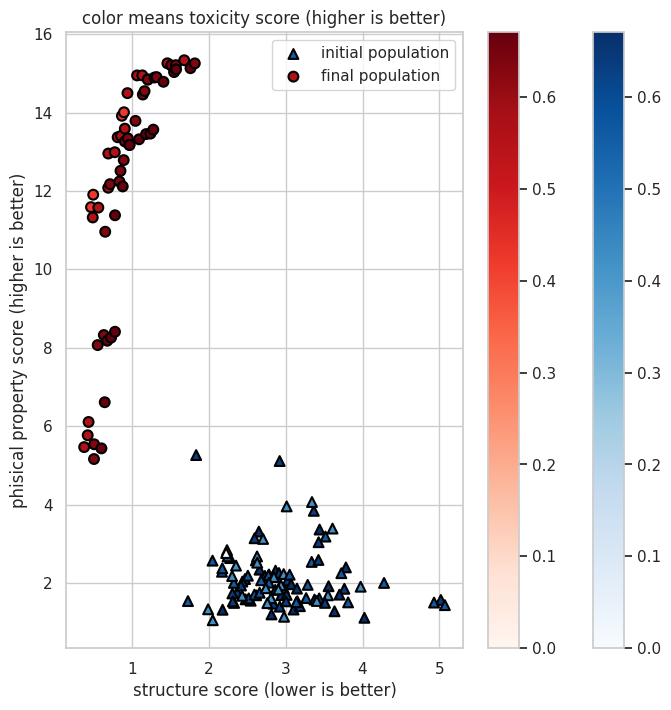

In [ ]:
init_pops= np.array(init_pops)
last_pops = np.array(pareto_front_pops)

x1 = init_pops[:, 0]  
y1 = init_pops[:, 1]  
c1 = init_pops[:, 2]

x2 = last_pops[:, 0] 
y2 = last_pops[:, 1]  
c2 = last_pops[:, 2]  

vmin = min(c1.min(), c2.min())
vmax = max(c1.max(), c2.max())

fig, ax = plt.subplots(figsize=(8, 8))

sc1 = ax.scatter(x1, y1, c=c1, cmap='Blues', vmin=vmin, vmax=vmax,  edgecolor='black', s=50, linewidth=1.5, label='initial population', marker="^")
sc2 = ax.scatter(x2, y2, c=c2, cmap='Reds', vmin=vmin, vmax=vmax,  edgecolor='black', s=50, linewidth=1.5, label='final population', marker="o")
cbar1 = plt.colorbar(sc1, ax=ax)
cbar2 = plt.colorbar(sc2, ax=ax)

ax.set_xlabel('structure score (lower is better)')
ax.set_ylabel('phisical property score (higher is better)')
ax.set_title('color means toxicity score (higher is better)')

# ax.set_xlim(-0.02, 0.4)
# ax.set_ylim(-0.02, 0.6)

os.makedirs(f"../../data/result/{test_name}/GA_{trys}/fig3", exist_ok=True)

ax.legend()
plt.savefig(f"../../data/result/{test_name}/GA_{trys}/fig3/fig3_parate.png")
plt.show()

# Result - fig4D

In [360]:
all_smiles = []
for i in range(len(cas_tox)):
    all_smiles.append(cas_tox.iloc[i,2])
    
smiles_list = []
for i in range(len(all_smiles)):
    if i in best_pop:
        smiles_list.append(all_smiles[i])

In [361]:
molecules = [Chem.MolFromSmiles(smiles) for smiles in smiles_list]

In [ ]:
os.makedirs(f"../../data/result/{test_name}/GA_{trys}/fig4", exist_ok=True)
fig = Chem.Draw.MolsToGridImage(molecules, molsPerRow=4, subImgSize=(500, 500))
with open(f"../../data/result/{test_name}/GA_{trys}/fig4/D_GA_chems.png", mode='wb') as f:
    f.write(fig.data)

# Run all tests

0701 START!


/opt/pip-env/lib/python3.10/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'Fitness' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/opt/pip-env/lib/python3.10/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


0701 DONE GA TIME: 683.7657012939453


/opt/pip-env/lib/python3.10/site-packages/rdkit/Chem/Draw/IPythonConsole.py:258: UserWarning: Truncating the list of molecules to be displayed to 50. Change the maxMols value to display more.
  warnings.warn(


0701 DONE GA TIME: 690.1719019412994
0702 START!


/opt/pip-env/lib/python3.10/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'Fitness' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/opt/pip-env/lib/python3.10/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


0702 DONE GA TIME: 511.2190251350403


/opt/pip-env/lib/python3.10/site-packages/rdkit/Chem/Draw/IPythonConsole.py:258: UserWarning: Truncating the list of molecules to be displayed to 50. Change the maxMols value to display more.
  warnings.warn(


0702 DONE GA TIME: 515.053542137146
0907 START!


/opt/pip-env/lib/python3.10/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'Fitness' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/opt/pip-env/lib/python3.10/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


0907 DONE GA TIME: 178.75091242790222
0907 DONE GA TIME: 180.95934462547302
1001 START!


/opt/pip-env/lib/python3.10/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'Fitness' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/opt/pip-env/lib/python3.10/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


1001 DONE GA TIME: 68.23605155944824
1001 DONE GA TIME: 69.90504956245422
1002 START!


/opt/pip-env/lib/python3.10/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'Fitness' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/opt/pip-env/lib/python3.10/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


1002 DONE GA TIME: 55.707988023757935
1002 DONE GA TIME: 57.786293506622314
0901_ago START!


/opt/pip-env/lib/python3.10/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'Fitness' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/opt/pip-env/lib/python3.10/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


0901_ago DONE GA TIME: 351.28912353515625


/tmp/ipykernel_2954911/4180453531.py:290: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig_1 = plt.figure()


0901_ago DONE GA TIME: 355.40357542037964
0901_anta START!


/opt/pip-env/lib/python3.10/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'Fitness' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/opt/pip-env/lib/python3.10/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


0901_anta DONE GA TIME: 176.98355388641357
0901_anta DONE GA TIME: 179.205420255661
0902_ago START!


/opt/pip-env/lib/python3.10/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'Fitness' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/opt/pip-env/lib/python3.10/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


0902_ago DONE GA TIME: 1026.8010268211365


/opt/pip-env/lib/python3.10/site-packages/rdkit/Chem/Draw/IPythonConsole.py:258: UserWarning: Truncating the list of molecules to be displayed to 50. Change the maxMols value to display more.
  warnings.warn(


0902_ago DONE GA TIME: 1031.0305845737457
0902_anta START!


/opt/pip-env/lib/python3.10/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'Fitness' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/opt/pip-env/lib/python3.10/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


0902_anta DONE GA TIME: 157.18434500694275
0902_anta DONE GA TIME: 159.3194625377655
0904_ago START!


/opt/pip-env/lib/python3.10/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'Fitness' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/opt/pip-env/lib/python3.10/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


0904_ago DONE GA TIME: 129.83808875083923
0904_ago DONE GA TIME: 131.64983820915222
0904_anta START!


/opt/pip-env/lib/python3.10/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'Fitness' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/opt/pip-env/lib/python3.10/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


0904_anta DONE GA TIME: 141.4761574268341
0904_anta DONE GA TIME: 143.51410746574402
0905_ago START!


/opt/pip-env/lib/python3.10/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'Fitness' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/opt/pip-env/lib/python3.10/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


0905_ago DONE GA TIME: 148.77498173713684
0905_ago DONE GA TIME: 150.60118675231934
0905_anta START!


/opt/pip-env/lib/python3.10/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'Fitness' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/opt/pip-env/lib/python3.10/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


0905_anta DONE GA TIME: 116.11983919143677
0905_anta DONE GA TIME: 117.88754343986511


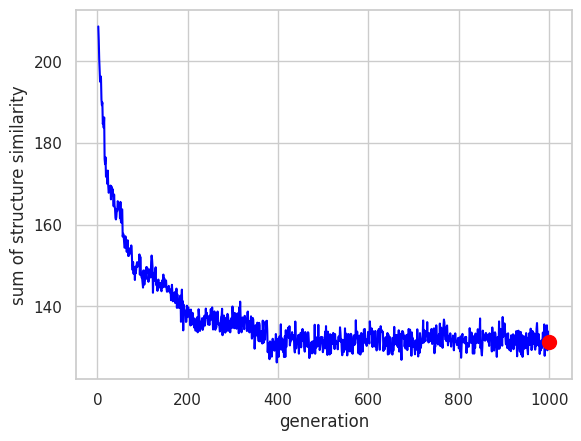

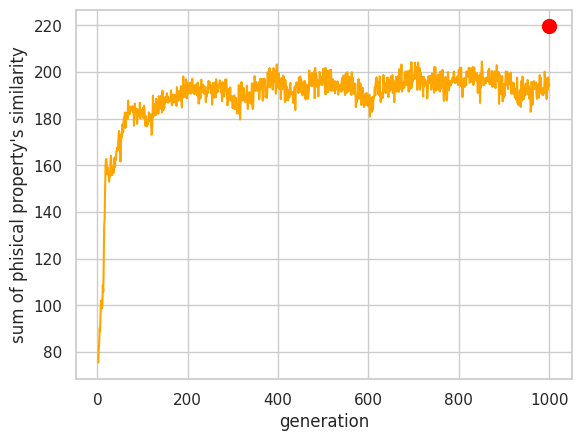

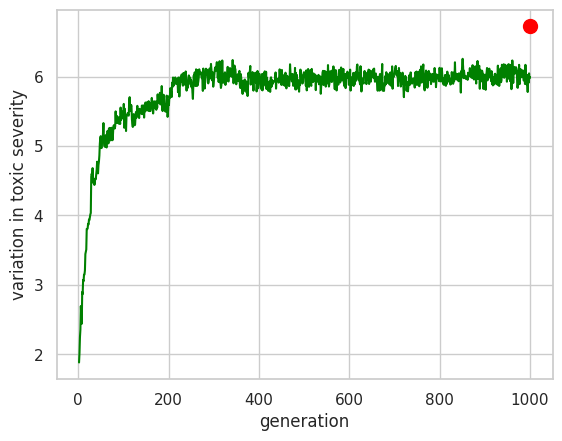

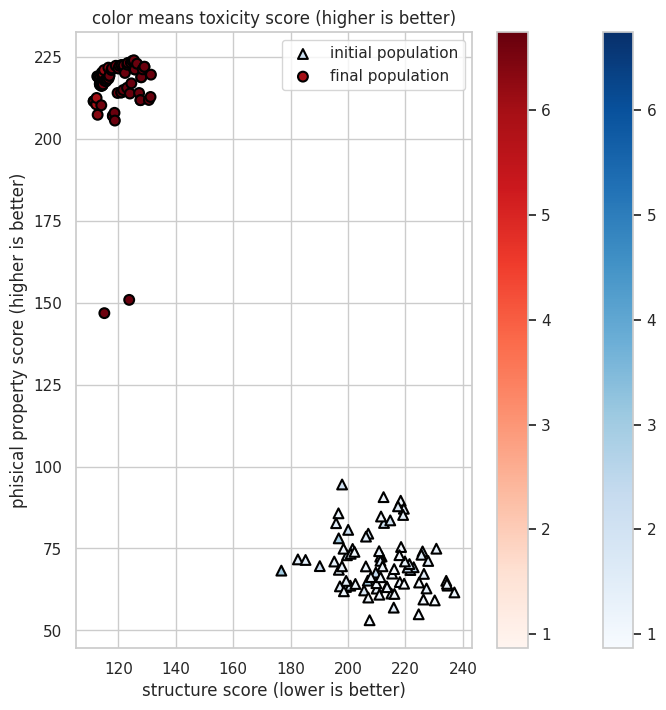

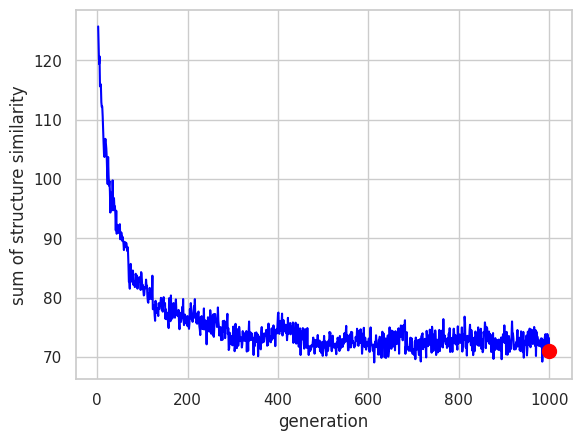

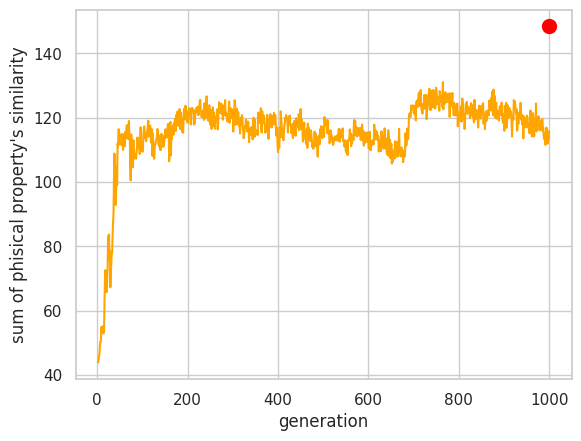

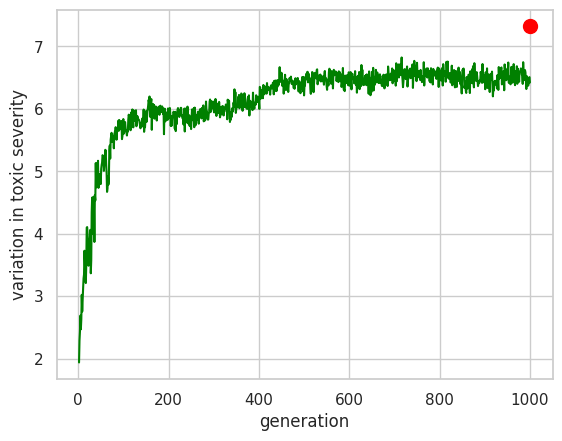

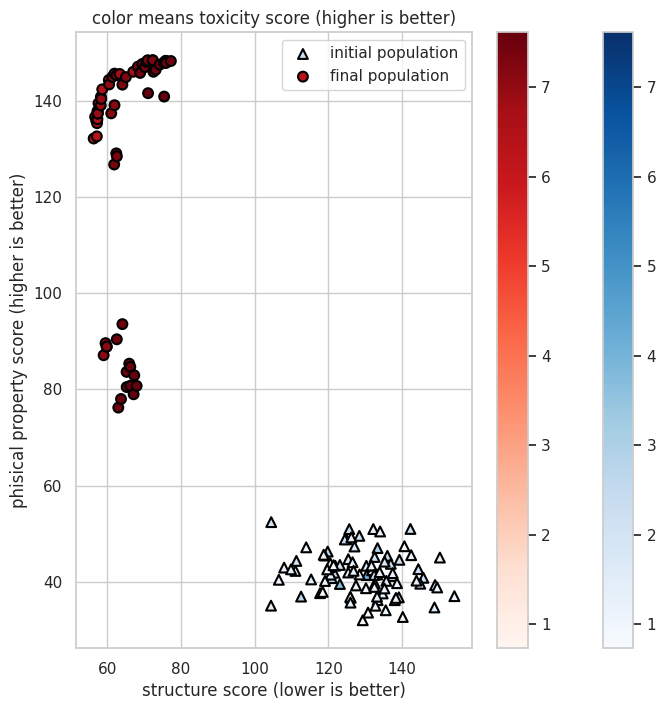

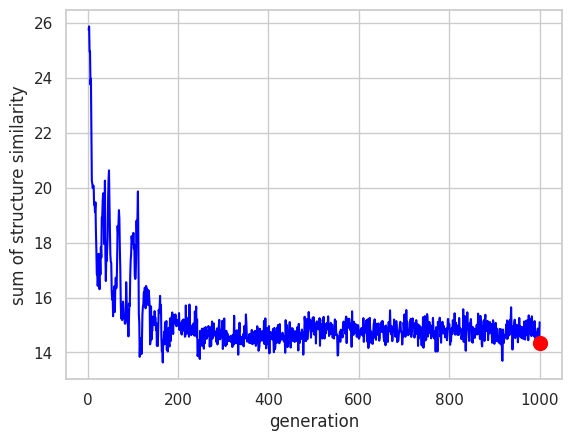

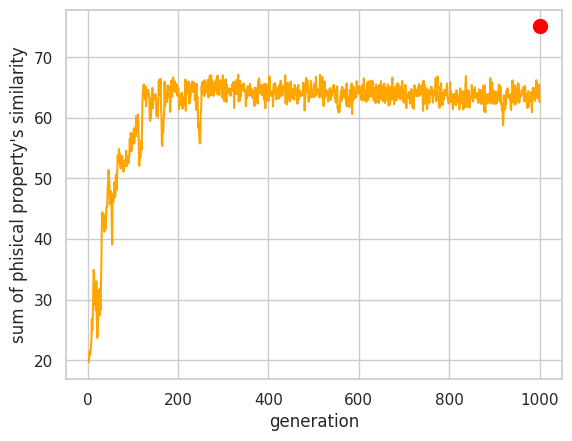

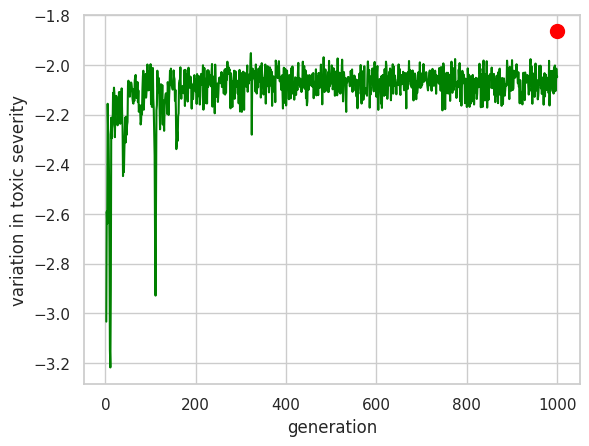

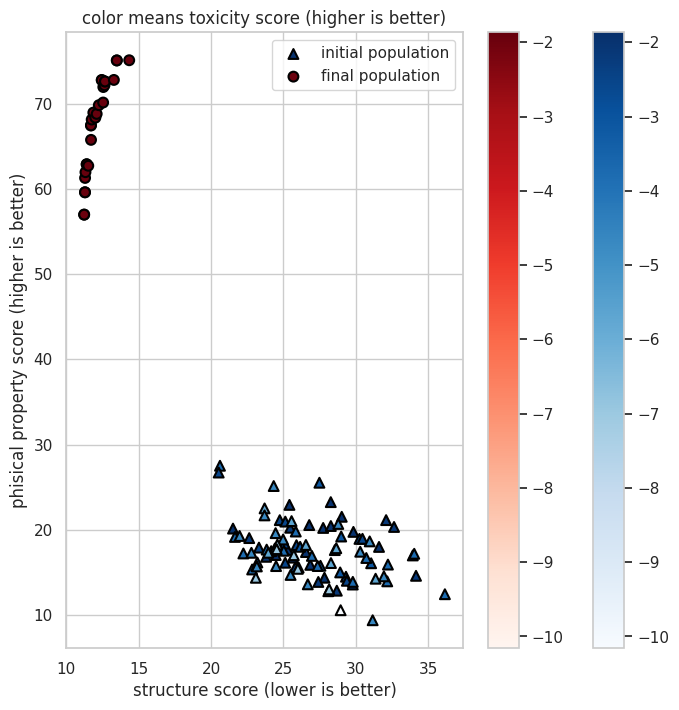

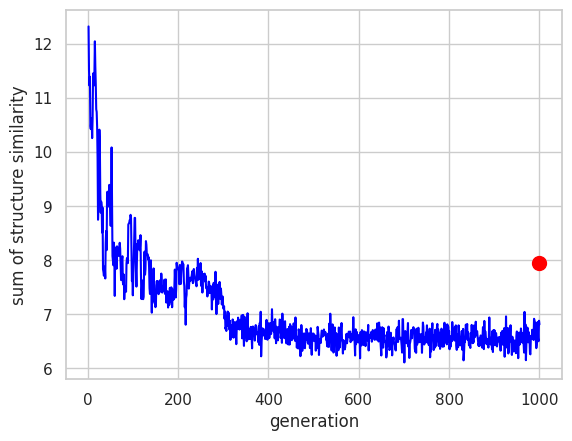

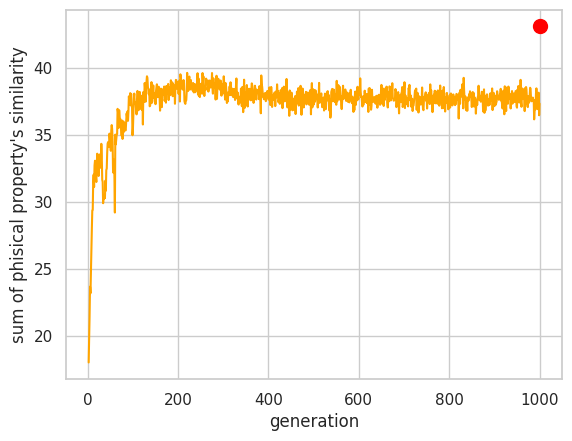

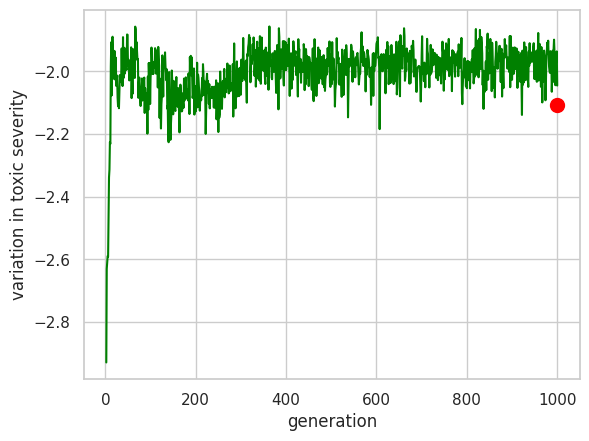

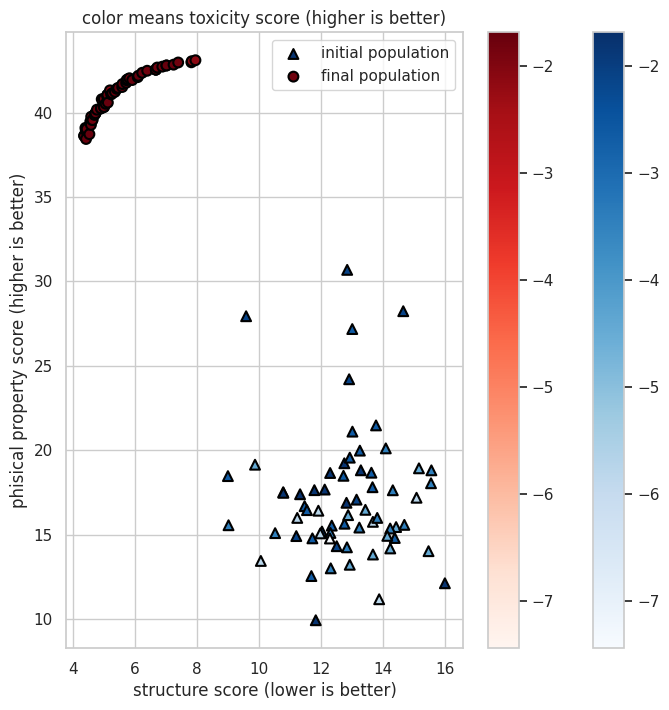

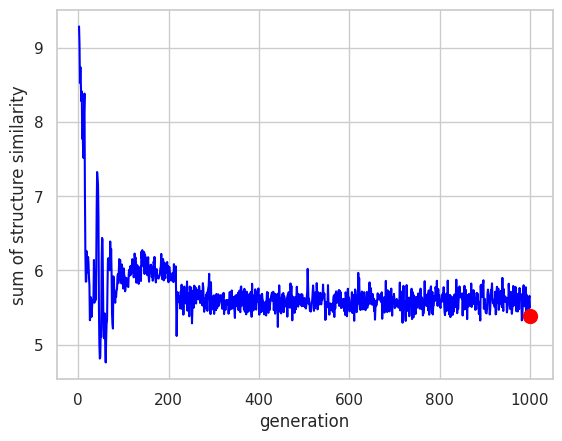

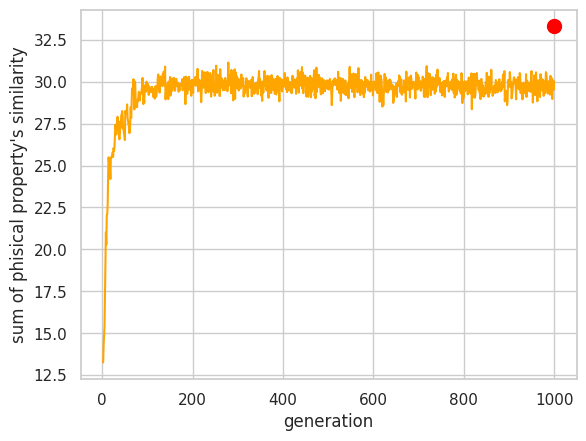

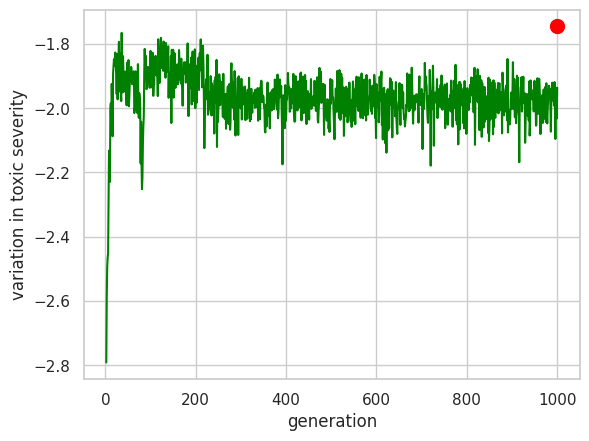

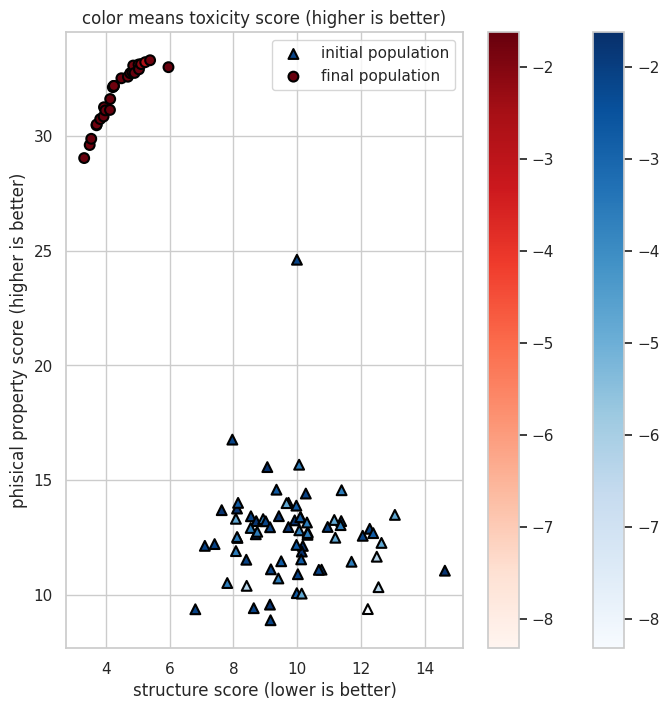

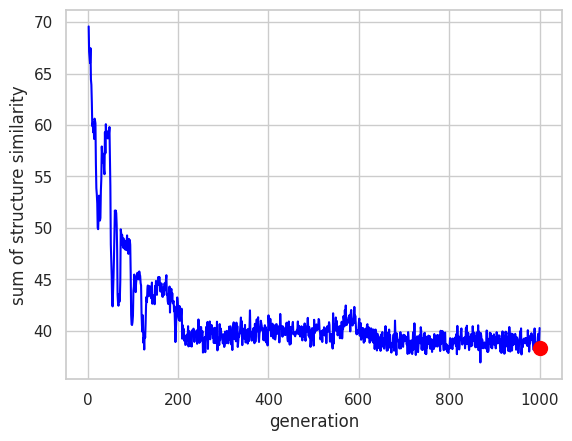

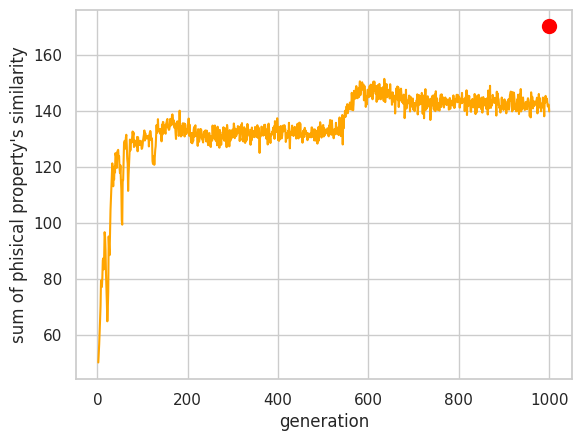

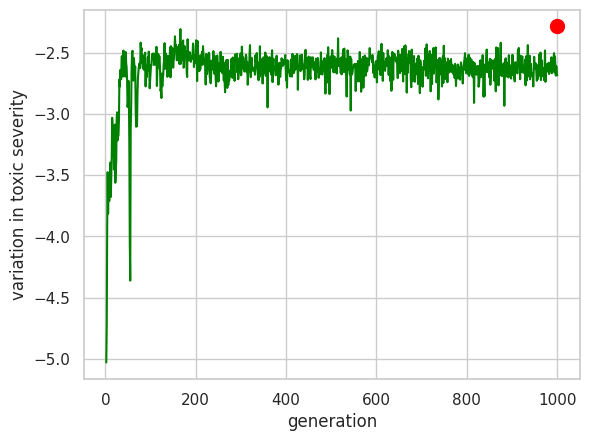

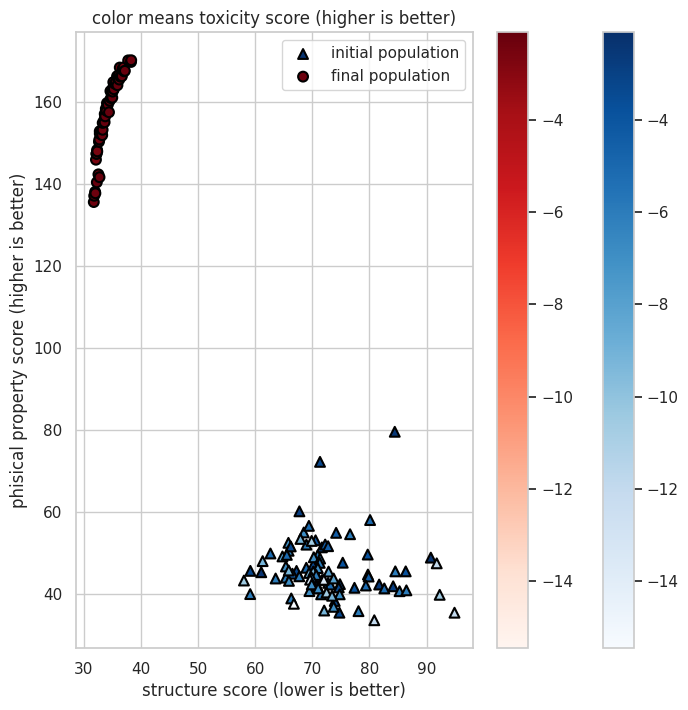

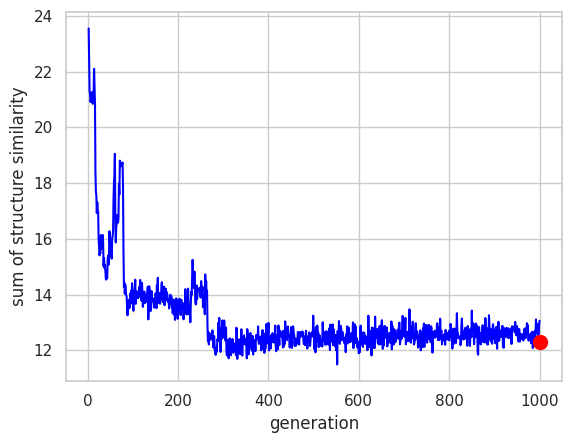

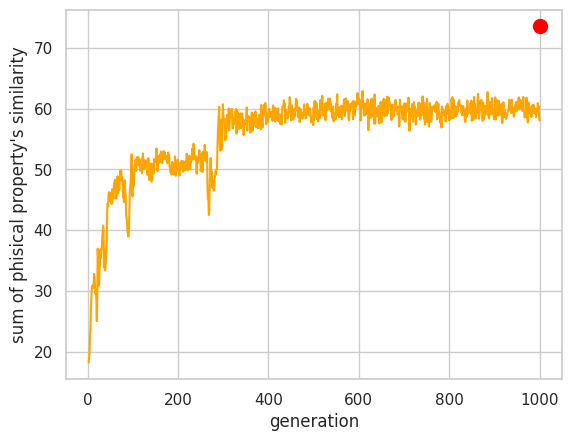

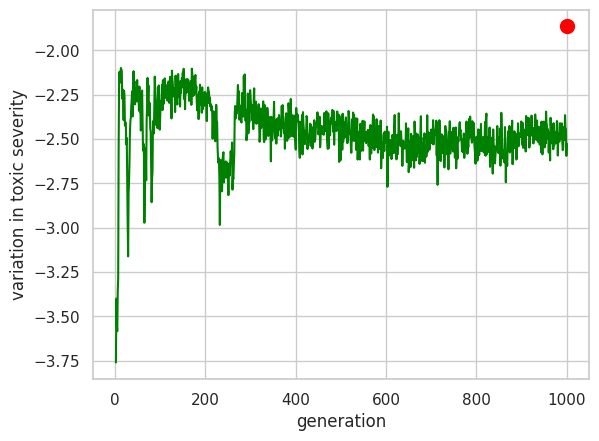

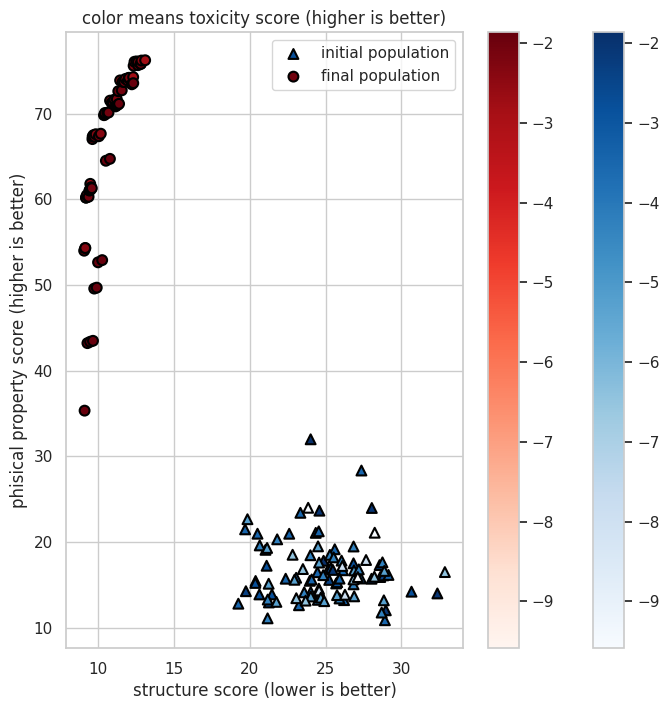

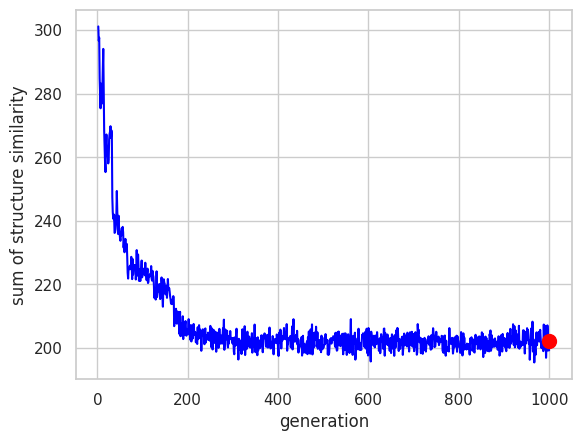

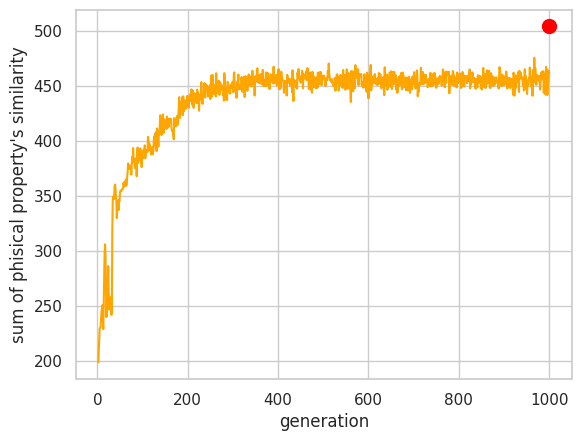

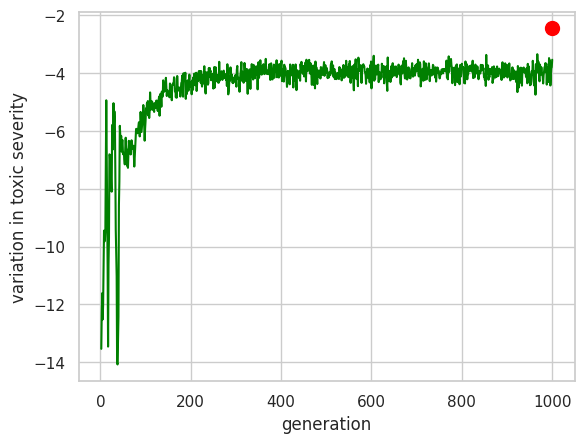

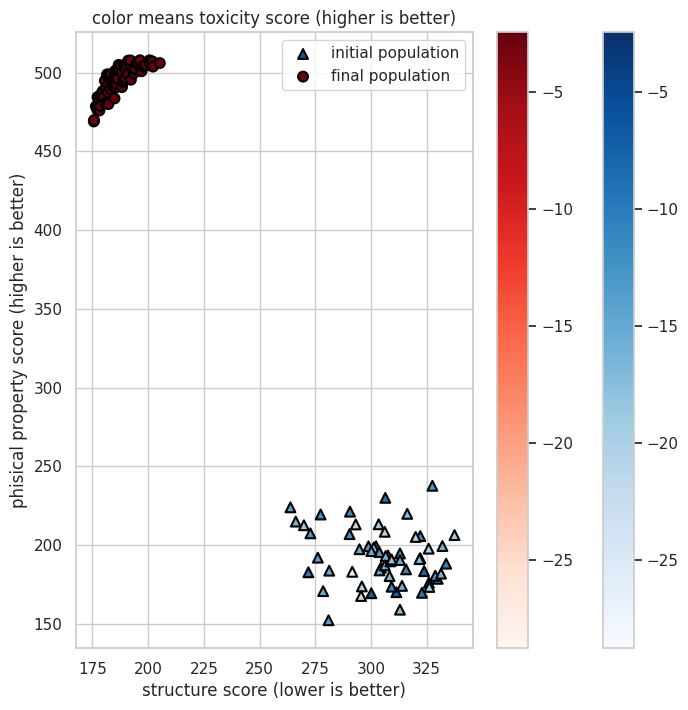

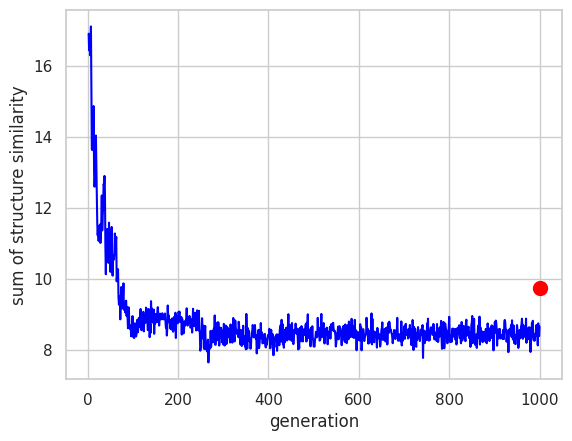

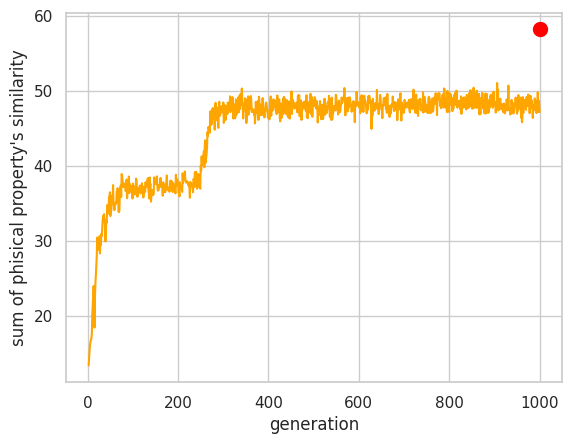

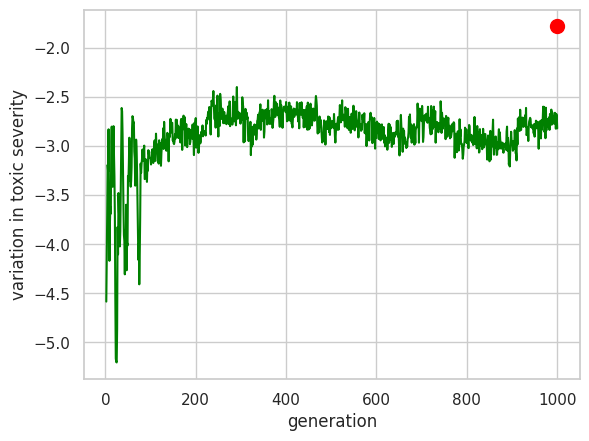

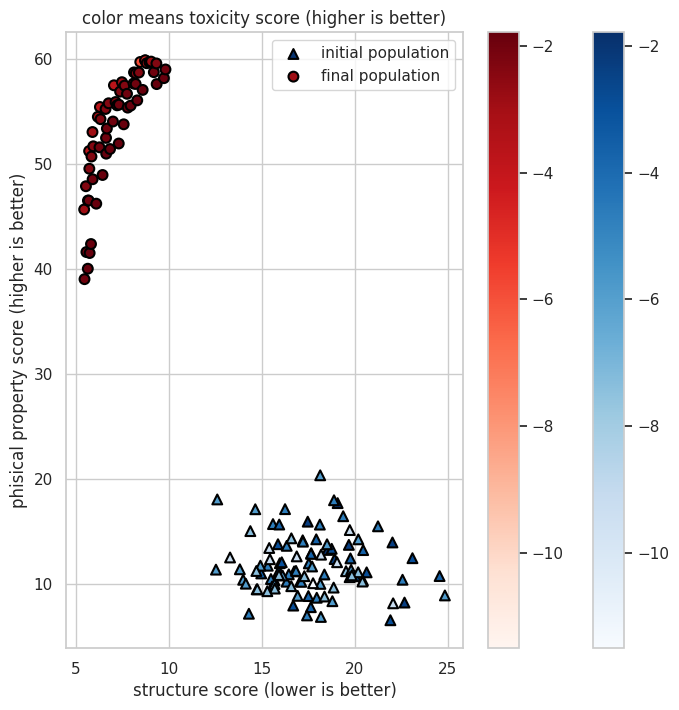

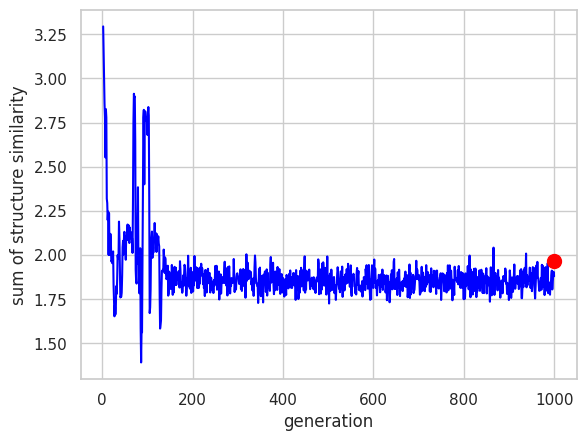

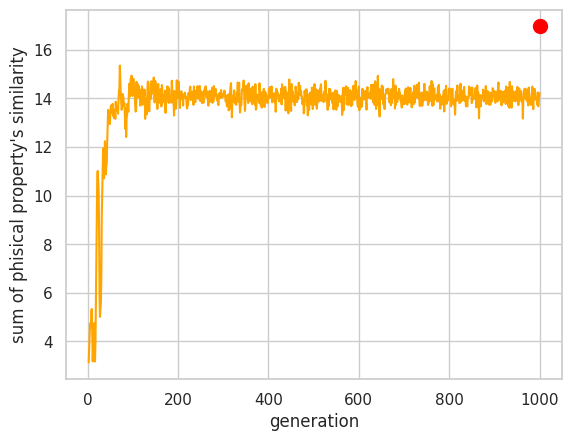

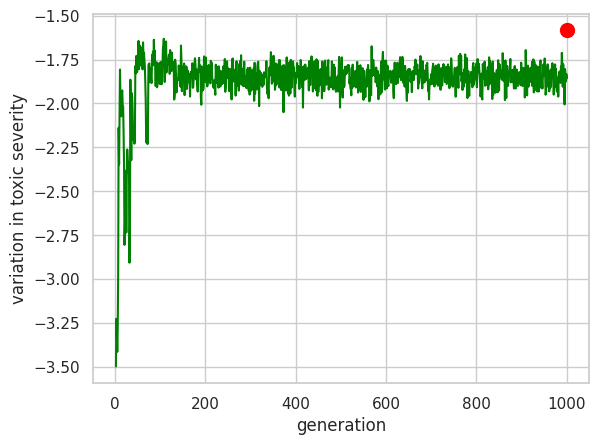

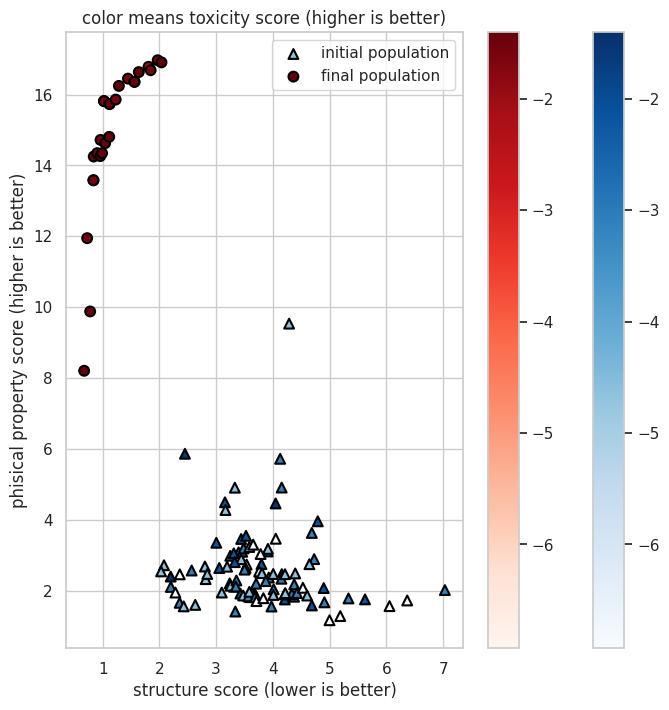

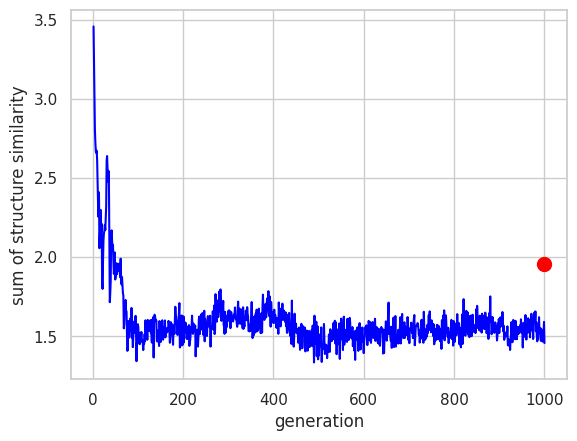

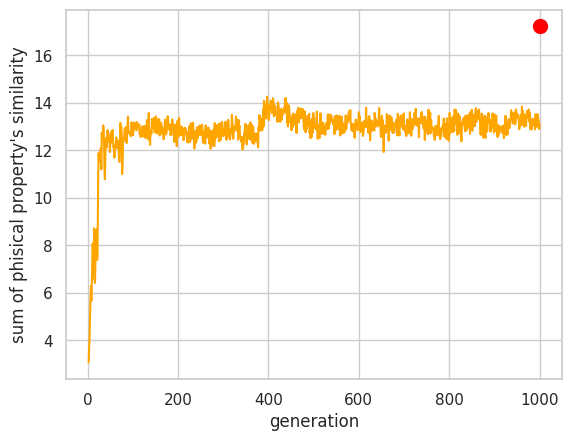

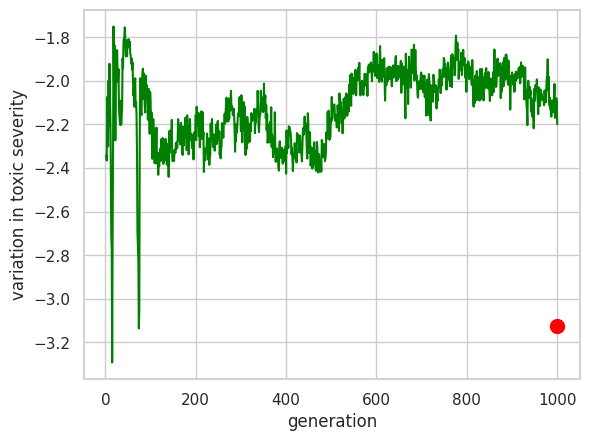

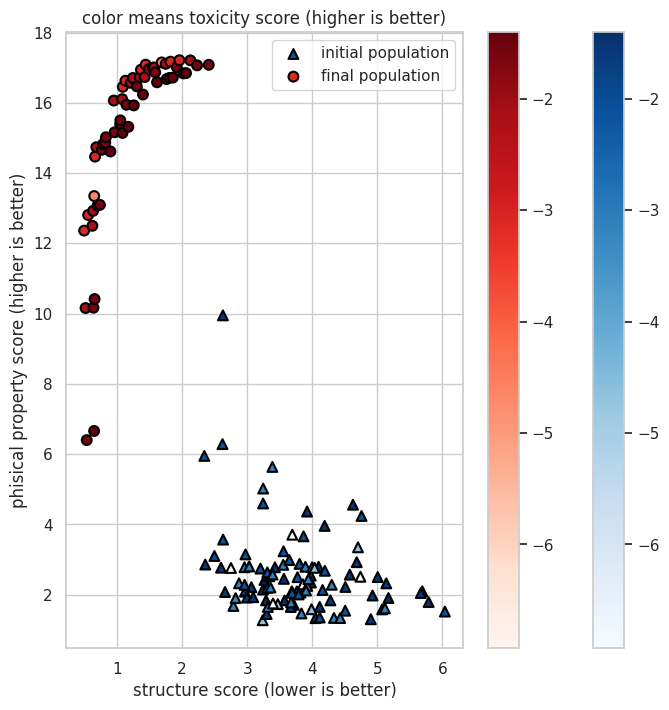

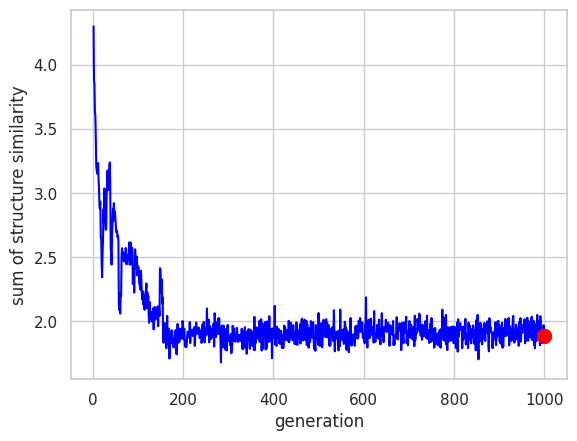

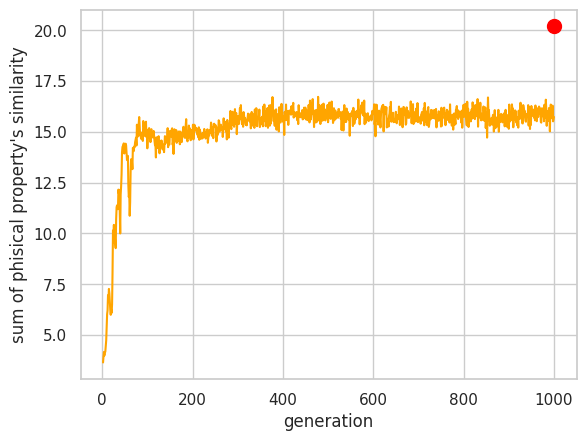

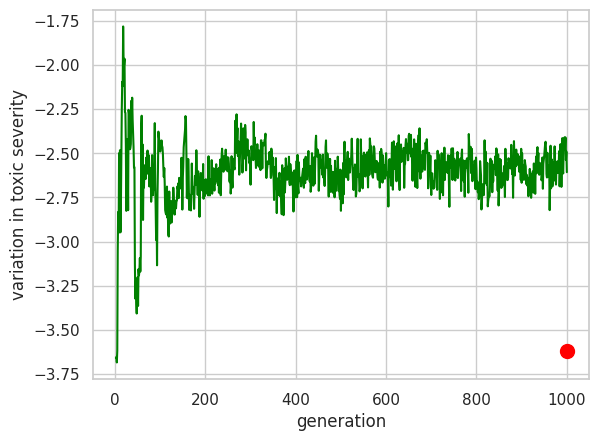

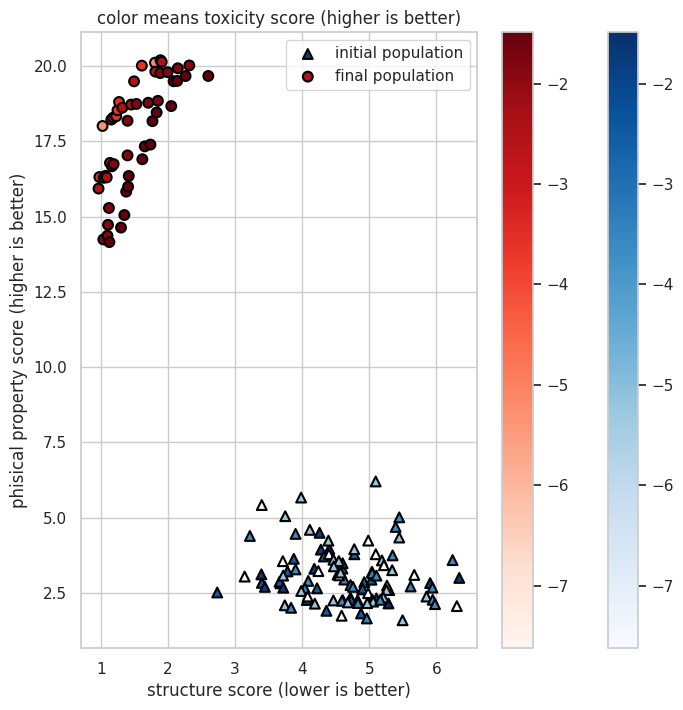

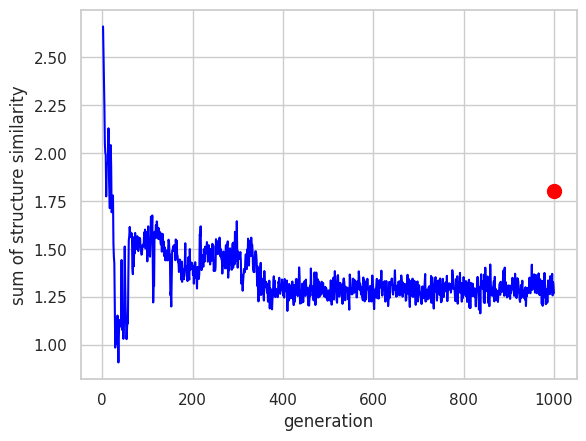

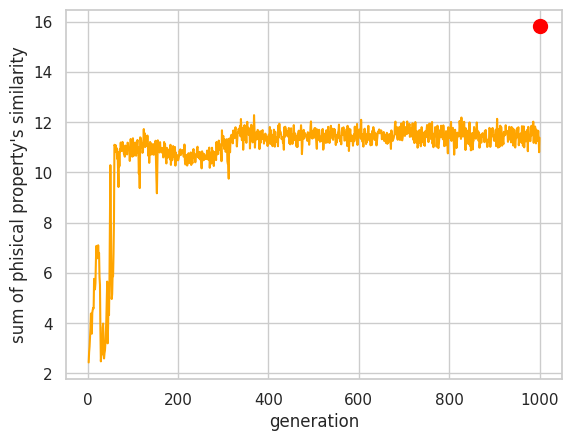

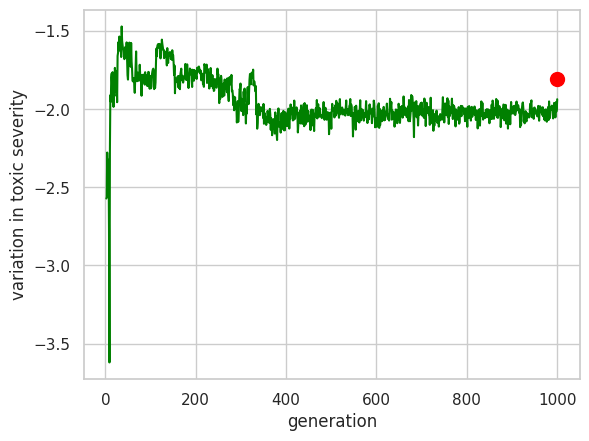

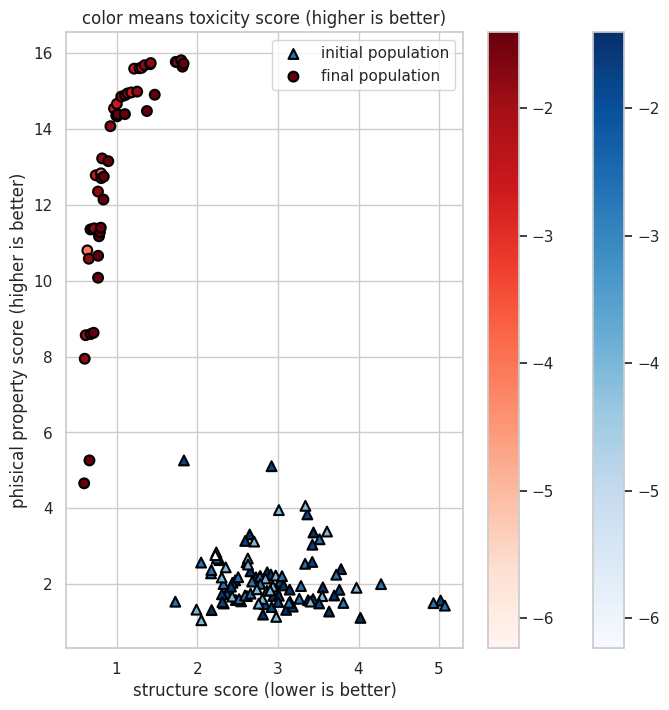

In [ ]:
for test_num in ["0701", "0702", "0907", "1001", "1002", "0901", "0902", "0904", "0905"]:
    for lig in ["ago", "anta"]:

        if test_num in ["0701", "0702", "0907", "1001", "1002"]:
            if lig == "ago":
                lig = "!"
            else:
                continue

        date = 241219
        num = 1

        if lig in ["ago", "anta"]:
            test_name = test_num + "_" + lig
        else:
            test_name = test_num
        print(test_name, "START!")
        start = time.time()
        
        lookup = pickle_load(f"../../data/processed/{test_name}/for_GA_lookup.pickle")
        cas_tox = pd.read_csv(f"../../data/processed/{test_name}/cas_sev_use.tsv", sep="\t", header=None)
        val = pd.read_csv(f"../../data/processed/{test_name}/validation_pubchem.tsv", sep="\t", header=None)

        os.makedirs(f"../../data/result/{test_name}/GA_{trys}/fig1", exist_ok=True)
        os.makedirs(f"../../data/result/{test_name}/GA_{trys}/fig2", exist_ok=True)
        os.makedirs(f"../../data/result/{test_name}/GA_{trys}/fig3", exist_ok=True)
        os.makedirs(f"../../data/result/{test_name}/GA_{trys}/fig4", exist_ok=True)
        os.makedirs(f"../../data/result/{test_name}/GA_{trys}/GA", exist_ok=True)
        
        #parameter
        N_GEN = 1000
        POP_SIZE = 100
        CX_PB = 0.5
        MUT_PB = 0.2
        weight = (-10,2,1)

        IND_INIT_SIZE = len(val)
        trys = str(date) + "_" + str(num)
        memo = f"""w = {weight}, date = {date}, num = {num}, gen = {N_GEN}, pop = {POP_SIZE} IND_INIT_SIZE = {IND_INIT_SIZE}, CX_PB = {CX_PB}, MUT_PB = {MUT_PB}"""

        all_cass = []
        all_toxs = []
        for i in range(len(cas_tox)):
            all_cass.append(cas_tox.iloc[i,0])
            all_toxs.append(cas_tox.iloc[i,1])

        if len(set(all_toxs)) == 2:
            tox_scoring = "descrete"
        else:
            tox_scoring = "continuous"

        if tox_scoring == "continuous":
            standardized_toxs = robust_z(all_toxs)
        elif tox_scoring == "descrete":
            standardized_toxs = all_toxs

        def multi_objective_optimization(individual):
            structure_score = 0
            phisical_score = 0
            penalty = [100000, -100000, -100000]

            if len(individual) != IND_INIT_SIZE:
                return penalty[0], penalty[1], penalty[2]
            
            toxs = []
            for i in range(len(list(individual))):
                num = list(individual)[i]
                toxs.append(standardized_toxs[num])

            if tox_scoring == "descrete":
                count_t = 0
                for i in range(len(toxs)):
                    if toxs[i] == 1:
                        count_t += 1
                N = len(toxs)
                p = 0.5
                likelihood = comb(N, count_t) * (p**count_t) * ((1 - p)**(N - count_t))
                toxicity_score = math.log(likelihood)

            elif tox_scoring == "continuous":
                toxicity_score = np.std(toxs)

            t = list(itertools.combinations(individual,2))
            for i in range(len(t)):
                if t[i][0] == t[i][1]:
                    print("!", flush=True)
                    return penalty[0], penalty[1], penalty[2]

            for i in range(len(t)):
                try:
                    dict_t = lookup[f"{all_cass[t[i][0]]}, {all_cass[t[i][1]]}"]
                except:
                    dict_t = lookup[f"{all_cass[t[i][1]]}, {all_cass[t[i][0]]}"]
                structure = dict_t[0]
                phisical = dict_t[1]
                structure_score += structure
                phisical_score += phisical

            return structure_score, phisical_score, toxicity_score

        creator.create("Fitness", base.Fitness, weights=weight)
        creator.create("Individual", set, fitness=creator.Fitness)

        toolbox = base.Toolbox()
        toolbox.register("attr_item", random.randint, 0, len(cas_tox)-1)
        toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_item, IND_INIT_SIZE)
        toolbox.register("population", tools.initRepeat, list, toolbox.individual)
        toolbox.register("evaluate", multi_objective_optimization, )
        toolbox.register("mate", cxSet)
        toolbox.register("mutate", mutSet)
        toolbox.register("select", tools.selNSGA2)

        def main(CX_PB, MUT_PB,IND_INIT_SIZE):
            random.seed(42)
            CX_PB = CX_PB
            MUT_PB = MUT_PB
            IND_INIT_SIZE = IND_INIT_SIZE
            tsv = []
            tsv_2 = []
            tsv_3 = []

            pop = toolbox.population(n=POP_SIZE)

            for x in range(len(pop)):
                if len(pop[x]) != IND_INIT_SIZE:
                    while len(pop[x]) == IND_INIT_SIZE:
                        pop[x].add(random.randint(0, len(cas_tox)-1))

            fitnesses = list(map(toolbox.evaluate, pop))
            for ind, fit in zip(pop, fitnesses):
                ind.fitness.values = fit

            fits = [ind.fitness.values[0] for ind in pop]

            g = 0
            while g < N_GEN:
                g = g + 1
                if g == 10:
                    now = time.ctime()
                    gentime = time.strptime(now)
                    # print(time.strftime("%Y/%m/%d %H:%M", gentime), flush=True)
                if g % 100 == 0:
                    now = time.ctime()
                    gentime = time.strptime(now)
                    # print(f"-------------------{g}------------------")
                    # print(time.strftime("%Y/%m/%d %H:%M", gentime), flush=True)
                offspring = toolbox.select(pop, 100)
                offspring = list(map(toolbox.clone, offspring))

                for child1, child2 in zip(offspring[::2], offspring[1::2]):
                    if random.random() < CX_PB:
                        child1, child2 = toolbox.mate(child1, child2)
                        del child1.fitness.values
                        del child2.fitness.values
                    
                    if len(child1) == IND_INIT_SIZE: 
                        offspring.append(child1)
                    if len(child2) == IND_INIT_SIZE:
                        offspring.append(child2)

                for mutant in offspring:
                    if random.random() < MUT_PB:
                        mutant = toolbox.mutate(mutant)
                        if mutant == 1:
                            continue
                        offspring.append(mutant)

                invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
                fitnesses = map(toolbox.evaluate, invalid_ind)
                for ind, fit in zip(invalid_ind, fitnesses):
                    ind.fitness.values = fit

                list_off = []
                for ind in offspring:
                    list_off.append(list(ind))
                
                list_a = []
                for ind in list_off:
                    if ind not in list_a:
                        list_a.append(ind)
                
                li_of = []
                for ind in list_a:
                    li_of.append(creator.Individual(ind))

                tsv_2.append(tools.selBest(li_of,100))

                pop[:] = offspring

                for x in range(len(pop)):
                    if len(pop[x]) != IND_INIT_SIZE:
                        while len(pop[x]) != IND_INIT_SIZE:
                            pop[x].add(random.randint(0, len(cas_tox)-1))
                
                col = []
                fits_0 = [ind.fitness.values[0] for ind in pop]

                length = len(pop)
                mean = sum(fits_0) / length
                sum2 = sum(x*x for x in fits_0)
                std = abs(sum2 / length - mean**2)**0.5
                col.append(mean)
                col.append(std)

                fits_1 = [ind.fitness.values[1] for ind in pop]

                length = len(pop)
                mean = sum(fits_1) / length
                sum2 = sum(x*x for x in fits_1)
                std = abs(sum2 / length - mean**2)**0.5
                col.append(mean)
                col.append(std)

                fits_2 = [ind.fitness.values[2] for ind in pop]

                length = len(pop)
                mean = sum(fits_2) / length
                sum2 = sum(x*x for x in fits_2)
                std = abs(sum2 / length - mean**2)**0.5
                col.append(mean)
                col.append(std)

                tsv.append(col)
                
                aaa = []
                for ind in pop:
                    col = []
                    for y in range(3):
                        col.append(ind.fitness.values[y])
                    aaa.append(col)
                tsv_3.append(aaa)

            best_ind = tools.selNSGA2(pop, 1)[0]
            # print("Best individual is %s, %s" % (best_ind, best_ind.fitness.values))
            
            try:
                os.makedirs(f"../../data/result/{test_name}/GA_{trys}/GA")
            except:
                pass

            pd.DataFrame(tsv).to_csv(f"../../data/result/{test_name}/GA_{trys}/GA/score.tsv", sep="\t", header=None, index=False)
            pd.DataFrame(tsv_2).to_csv(f"../../data/result/{test_name}/GA_{trys}/GA/top_5.tsv", sep="\t", header=None, index=False)
            pd.DataFrame(tsv_3).to_csv(f"../../data/result/{test_name}/GA_{trys}/GA/data.tsv", sep="\t", header=None, index=False)
            with open(f"../../data/result/{test_name}/GA_{trys}/GA/memo.txt", "w") as f:
                f.write(memo)

            pareto_front = tools.ParetoFront()
            pareto_front.update(pop)
            pd.DataFrame(pareto_front).to_csv(f"../../data/result/{test_name}/GA_{trys}/GA/pareto_front.tsv", sep="\t", header=None, index=False)

        # print(IND_INIT_SIZE)
        if __name__ == "__main__":
            main(CX_PB, MUT_PB, IND_INIT_SIZE)
        # now = time.ctime()
        # cnvtime = time.strptime(now)
        # print(time.strftime("%Y/%m/%d %H:%M", cnvtime), flush=True)

        end = time.time()
        time_diff = end - start
        print(f"{test_name} DONE GA TIME:", time_diff)
    
        pops = pd.read_csv(f"../../data/result/{test_name}/GA_{trys}/GA/top_5.tsv", sep="\t", header=None)
        best_pop = pops.iloc[-1,0]
        best_pop = best_pop.replace("Individual(", "").replace(")", "")
        best_pop = list(ast.literal_eval(best_pop))
        best_score = multi_objective_optimization(best_pop)

        scores = pd.read_csv(f"../../data/result/{test_name}/GA_{trys}/GA/score.tsv", sep="\t", header=None)
        n = 1000
        m_tani = []
        s_tani = []
        m_butsu = []
        s_butsu = []
        m_tox = []
        s_tox = []
        m_mw = []
        s_mw = []


        for i in range(1, n):
            m_tani.append(scores.iloc[i,0])
            s_tani.append(scores.iloc[i,1])
            m_butsu.append(scores.iloc[i,2])
            s_butsu.append(scores.iloc[i,3])
            m_tox.append(scores.iloc[i,4])
            s_tox.append(scores.iloc[i,5])
            #m_mw.append(scores.iloc[i,6])
            #s_mw.append(scores.iloc[i,7])

        plt.style.use('default')
        sns.set()
        sns.set_style('whitegrid')
        sns.set_palette('Set1')

        x = list(range(2, n+1))

        fig_1 = plt.figure()
        ax_1 = fig_1.add_subplot(1, 1, 1)

        ax_1.plot(x, m_tani, label='similaryty of chemical structures', color= "blue")
        ax_1.plot(1000, best_score[0], marker=".", color="red", markersize=20)
        #ax_1.legend(prop={'family':'Yu Gothic'})
        ax_1.set_xlabel("generation")
        ax_1.set_ylabel("sum of structure similarity")
        plt.savefig(f"../../data/result/{test_name}/GA_{trys}/fig2/A_structure.png")

        fig_2 = plt.figure()
        ax_2 = fig_2.add_subplot(1, 1, 1)

        #ax_1.errorbar(x, m_tani, yerr=s_tani, marker='o', capthick=1, capsize=10, lw=1,  alpha=0.2)
        ax_2.plot(x, m_butsu, label='similarity among chemical propaties', color="orange")
        ax_2.plot(1000, best_score[1], marker=".", color="red", markersize=20)
        #ax_2.legend(prop={'family':'Yu Gothic'})
        ax_2.set_xlabel("generation")
        ax_2.set_ylabel("sum of phisical property's similarity")
        plt.savefig(f"../../data/result/{test_name}/GA_{trys}/fig2/C_phisical_property.png")
        #ax_2.errorbar(x, m_butsu, yerr=s_butsu, marker='o', capthick=1, capsize=10, lw=1, alpha=0.2, color="blue")

        fig_3 = plt.figure()
        ax_3 = fig_3.add_subplot(1, 1, 1)

        ax_3.plot(x, m_tox, label='variation in toxic severity', color="green")
        ax_3.plot(1000, best_score[2], marker=".", color="red", markersize=20)
        #ax_3.legend(prop={'family':'Yu Gothic'})
        ax_3.set_xlabel("generation")
        ax_3.set_ylabel("variation in toxic severity")
        plt.savefig(f"../../data/result/{test_name}/GA_{trys}/fig2/B_toxicity.png")
        #ax_3.errorbar(x, m_tox, yerr=s_tox, marker='o', capthick=1, capsize=10, lw=1,  alpha=0.2)
        #ax_3.plot(1000, s[2], marker=".", color="red", markersize=20)
        #ax_3.errorbar(x, m_mw, yerr=s_mw, marker='o', capthick=1, capsize=10, lw=1)
        # plt.show()

        init_pops = []
        for i in range(len(pops.iloc[0])):
            init_pop = pops.iloc[0,i]
            init_pop = init_pop.replace("Individual(", "").replace(")", "")
            init_pop = list(ast.literal_eval(init_pop))
            scores = multi_objective_optimization(init_pop)
            if scores[0] <= 1e4:
                init_pops.append(multi_objective_optimization(init_pop))

        pareto_front = pd.read_csv(f"../../data/result/{test_name}/GA_{trys}/GA/pareto_front.tsv", sep="\t", header=None)
        pareto_front_pops = []

        for i in range(len(pareto_front)):
            pop = []
            for n in range(len(pareto_front.iloc[i])):
                pop.append(pareto_front.iloc[i,n])
            pareto_front_pops.append(multi_objective_optimization(pop))

        init_pops= np.array(init_pops)
        last_pops = np.array(pareto_front_pops)

        x1 = init_pops[:, 0]  
        y1 = init_pops[:, 1]  
        c1 = init_pops[:, 2]

        x2 = last_pops[:, 0] 
        y2 = last_pops[:, 1]  
        c2 = last_pops[:, 2]  

        vmin = min(c1.min(), c2.min())
        vmax = max(c1.max(), c2.max())

        fig, ax = plt.subplots(figsize=(8, 8))

        sc1 = ax.scatter(x1, y1, c=c1, cmap='Blues', vmin=vmin, vmax=vmax,  edgecolor='black', s=50, linewidth=1.5, label='initial population', marker="^")
        sc2 = ax.scatter(x2, y2, c=c2, cmap='Reds', vmin=vmin, vmax=vmax,  edgecolor='black', s=50, linewidth=1.5, label='final population', marker="o")
        cbar1 = plt.colorbar(sc1, ax=ax)
        cbar2 = plt.colorbar(sc2, ax=ax)

        ax.set_xlabel('structure score (lower is better)')
        ax.set_ylabel('phisical property score (higher is better)')
        ax.set_title('color means toxicity score (higher is better)')

        # ax.set_xlim(-0.02, 0.4)
        # ax.set_ylim(-0.02, 0.6)

        ax.legend()
        plt.savefig(f"../../data/result/{test_name}/GA_{trys}/fig3/fig3_parate.png")
        # plt.show()

        all_smiles = []
        for i in range(len(cas_tox)):
            all_smiles.append(cas_tox.iloc[i,2])
            
        smiles_list = []
        for i in range(len(all_smiles)):
            if i in best_pop:
                smiles_list.append(all_smiles[i])
        molecules = [Chem.MolFromSmiles(smiles) for smiles in smiles_list]

        fig = Chem.Draw.MolsToGridImage(molecules, molsPerRow=4, subImgSize=(500, 500))
        with open(f"../../data/result/{test_name}/GA_{trys}/fig4/D_GA_chems.png", mode='wb') as f:
            f.write(fig.data)

        end = time.time()
        time_diff = end - start
        print(f"{test_name} DONE GA TIME:", time_diff)

In [ ]:
for test_num in ["0701", "0702", "0907", "1001", "1002", "0901", "0902", "0904", "0905"]:
    for lig in ["ago", "anta"]:
        if test_num in ["0701", "0702", "0907", "1001", "1002"]:
            if lig == "ago":
                lig = "!"
            else:
                continue

        if lig in ["ago", "anta"]:
            test_name = test_num + "_" + lig
        else:
            test_name = test_num

        validation = pd.read_csv(f"../../data/processed/{test_name}/validation_pubchem.tsv", sep="\t", header=None)
        smiles_list = validation[2]
        molecules = [Chem.MolFromSmiles(smiles) for smiles in smiles_list]

        os.makedirs(f"../../data/result/{test_name}/GA_{trys}/fig1", exist_ok=True)

        fig = Chem.Draw.MolsToGridImage(molecules, molsPerRow=4, subImgSize=(500, 500))
        with open(f"../../data/result/{test_name}/GA_{trys}/fig1/D_valid_chems.png", mode='wb') as f:
            f.write(fig.data)

/opt/250102_test_env/lib/python3.11/site-packages/rdkit/Chem/Draw/IPythonConsole.py:344: UserWarning: Truncating the list of molecules to be displayed to 50. Change the maxMols value to display more.
  warnings.warn(
/opt/250102_test_env/lib/python3.11/site-packages/rdkit/Chem/Draw/IPythonConsole.py:344: UserWarning: Truncating the list of molecules to be displayed to 50. Change the maxMols value to display more.
  warnings.warn(
/opt/250102_test_env/lib/python3.11/site-packages/rdkit/Chem/Draw/IPythonConsole.py:344: UserWarning: Truncating the list of molecules to be displayed to 50. Change the maxMols value to display more.
  warnings.warn(
